In [1]:
# Input:
path_x_train = '/content/X_train.csv'
path_x_val = '/content/X_val.csv'
path_y_train = '/content/y_train.csv'
path_y_val = '/content/y_val.csv'
path_test = '/content/test.csv'
n_outputs = 4
input_dim = 5000
metrics = ['accuracy']
epochs=15
batch_size=500
model_name='text_classifier.hdf5'
monitor='val_accuracy'
mode='max'
patience=5
test_score, val_score = 'accuracy', 'val_accuracy'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, \
GlobalMaxPooling1D, Flatten, SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.models import load_model

In [3]:
# Load data
X_train = pd.read_csv(path_x_train, index_col='Unnamed: 0')
X_val = pd.read_csv(path_x_val, index_col='Unnamed: 0')
y_train = pd.read_csv(path_y_train, index_col='Unnamed: 0')
y_val = pd.read_csv(path_y_val, index_col='Unnamed: 0')

In [8]:
# Apply tokenizer and sequence
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(X_train['cleaned_text'].values)

seq_train = tokenizer.texts_to_sequences(X_train['cleaned_text'].values)
seq_val = tokenizer.texts_to_sequences(X_val['cleaned_text'].values)

pad_train = pad_sequences(seq_train)
pad_val = pad_sequences(seq_val)

# number of word index
len(tokenizer.word_index)

6416

In [9]:
# save the tokenizer
pickle.dump(tokenizer, open('text_emotion_tokenizer.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

# Build neural network architecture

In [10]:
# Dense model architecture
def build_dense_model(input_dim, n_outputs):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim=64))
    model.add(GlobalAveragePooling1D()) # reduce the number of parameters and avoid overfitting.
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)

    return model

In [20]:
# LSTM model architecture
def build_lstm_model(input_dim, n_outputs):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim=64))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)

    return model

In [11]:
# Bi-LSTM
def build_bi_lstm_model(input_dim, n_outputs, metrics):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim=64))
    model.add(Bidirectional(LSTM(32, return_sequences = False))) # For bidirectional-GRU, replace LSTM with GRU
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid')) # or use softmax
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)

    return model

In [12]:
# GRU
def build_gru_model(input_dim, n_outputs, metrics):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim=64))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(64, return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)

    return model

In [13]:
# CNN
def build_cnn_model(input_dim, n_outputs, metrics):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim=64))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)

    return model

In [31]:
# CNN + GRU
def build_cnn_gru_model(input_dim, n_outputs, metrics):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim=64))
    model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(GRU(16, recurrent_dropout=0.5))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)

    return model

In [15]:
# Set callbacks
def create_callbacks(model_name, monitor, mode, patience):
    # Early stopping
    es = EarlyStopping(
        monitor=monitor, mode=mode, verbose=0, patience=patience, restore_best_weights=True
    )

    # Checkpoint
    checkpoint = ModelCheckpoint(
        filepath=model_name,
        monitor=monitor,
        mode=mode,
        save_best_only=True
    )

    return es, checkpoint

In [16]:
# Fit model
def fit_model(model, es, checkpoint):
    model_history = model.fit(
        pad_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size
        validation_data=(pad_val, y_val),
        callbacks=[checkpoint, es],
        verbose=2,
    )
    return model, model_history

In [17]:
# Plot model history
def plot_history(model_history, test_score, val_score):
    # Visualize the CNN training history
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    # Accuracy
    ax[0].plot(model_history.history[test_score])
    ax[0].plot(model_history.history[val_score])
    ax[0].set_title(test_score)
    ax[0].set_ylabel(test_score)
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    # Loss
    ax[1].plot(model_history.history['loss'])
    ax[1].plot(model_history.history['val_loss'])
    ax[1].set_title('loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()

# Fit the model

## Dense

In [18]:
# Create callbacks
es, checkpoint = create_callbacks('text_classifier_dense.hdf5', monitor, mode, patience)
# Build model architecture
model_dense = build_dense_model(input_dim, n_outputs, metrics)
# Fit the model
model_dense, model_dense_history = fit_model(model_dense, es, checkpoint)

Epoch 1/15
91/91 - 1s - loss: 1.3782 - accuracy: 0.3156 - val_loss: 1.3653 - val_accuracy: 0.3320 - 1s/epoch - 13ms/step
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 - 0s - loss: 1.3198 - accuracy: 0.4201 - val_loss: 1.2324 - val_accuracy: 0.5546 - 324ms/epoch - 4ms/step
Epoch 3/15
91/91 - 0s - loss: 1.0599 - accuracy: 0.5744 - val_loss: 0.9350 - val_accuracy: 0.6556 - 341ms/epoch - 4ms/step
Epoch 4/15
91/91 - 0s - loss: 0.7535 - accuracy: 0.7308 - val_loss: 0.7169 - val_accuracy: 0.7372 - 355ms/epoch - 4ms/step
Epoch 5/15
91/91 - 0s - loss: 0.5090 - accuracy: 0.8377 - val_loss: 0.5737 - val_accuracy: 0.8230 - 347ms/epoch - 4ms/step
Epoch 6/15
91/91 - 0s - loss: 0.3258 - accuracy: 0.9131 - val_loss: 0.4973 - val_accuracy: 0.8409 - 268ms/epoch - 3ms/step
Epoch 7/15
91/91 - 0s - loss: 0.2185 - accuracy: 0.9408 - val_loss: 0.4632 - val_accuracy: 0.8437 - 325ms/epoch - 4ms/step
Epoch 8/15
91/91 - 0s - loss: 0.1740 - accuracy: 0.9567 - val_loss: 0.4566 - val_accuracy: 0.8589 - 352ms/epoch - 4ms/step
Epoch 9/15
91/91 - 1s - loss: 0.1325 - accuracy: 0.9630 - val_loss: 0.4690 - val_accuracy: 0.8423 - 540ms/epoch - 6ms/step
Epoch 10/15
91/91 - 0s - lo

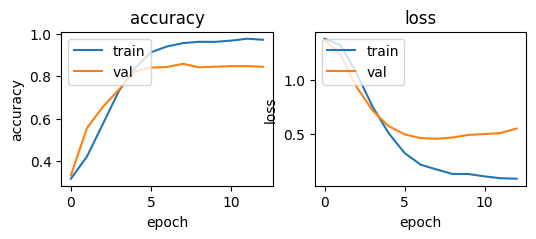

In [23]:
# Plot model history
plot_history(model_dense_history, test_score, val_score)

## LSTM

In [21]:
# Create callbacks
es, checkpoint = create_callbacks('text_classifier_lstm.hdf5', monitor, mode, patience)
# Build model architecture
model_lstm = build_lstm_model(input_dim, n_outputs, metrics)
# Fit the model
model_lstm, model_lstm_history = fit_model(model_lstm, es, checkpoint)

Epoch 1/15
91/91 - 4s - loss: 1.3610 - accuracy: 0.3467 - val_loss: 1.3183 - val_accuracy: 0.3430 - 4s/epoch - 39ms/step
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 - 1s - loss: 1.0283 - accuracy: 0.5242 - val_loss: 0.8748 - val_accuracy: 0.6376 - 835ms/epoch - 9ms/step
Epoch 3/15
91/91 - 1s - loss: 0.5375 - accuracy: 0.8412 - val_loss: 0.5831 - val_accuracy: 0.8188 - 820ms/epoch - 9ms/step
Epoch 4/15
91/91 - 1s - loss: 0.2273 - accuracy: 0.9377 - val_loss: 0.5397 - val_accuracy: 0.8368 - 844ms/epoch - 9ms/step
Epoch 5/15
91/91 - 1s - loss: 0.1528 - accuracy: 0.9616 - val_loss: 0.5629 - val_accuracy: 0.8257 - 820ms/epoch - 9ms/step
Epoch 6/15
91/91 - 1s - loss: 0.1072 - accuracy: 0.9754 - val_loss: 0.5756 - val_accuracy: 0.8299 - 811ms/epoch - 9ms/step
Epoch 7/15
91/91 - 1s - loss: 0.0920 - accuracy: 0.9782 - val_loss: 0.5910 - val_accuracy: 0.8257 - 835ms/epoch - 9ms/step
Epoch 8/15
91/91 - 1s - loss: 0.0830 - accuracy: 0.9792 - val_loss: 0.5839 - val_accuracy: 0.8354 - 834ms/epoch - 9ms/step
Epoch 9/15
91/91 - 1s - loss: 0.0677 - accuracy: 0.9834 - val_loss: 0.6478 - val_accuracy: 0.8354 - 844ms/epoch - 9ms/step


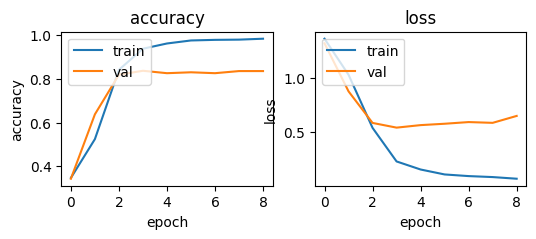

In [22]:
# Plot model history
plot_history(model_lstm_history, test_score, val_score)

## Bi-LSTM

In [24]:
# Create callbacks
es, checkpoint = create_callbacks('text_classifier_bi-lstm.hdf5', monitor, mode, patience)
# Build model architecture
model_bi_lstm = build_bi_lstm_model(input_dim, n_outputs, metrics)
# Fit the model
model_bi_lstm, model_bi_lstm_history = fit_model(model_bi_lstm, es, checkpoint)

Epoch 1/15
91/91 - 5s - loss: 1.3608 - accuracy: 0.3301 - val_loss: 1.2846 - val_accuracy: 0.3444 - 5s/epoch - 56ms/step
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 - 1s - loss: 0.9019 - accuracy: 0.6502 - val_loss: 0.6843 - val_accuracy: 0.7497 - 1s/epoch - 12ms/step
Epoch 3/15
91/91 - 1s - loss: 0.3392 - accuracy: 0.8920 - val_loss: 0.4770 - val_accuracy: 0.8313 - 1s/epoch - 12ms/step
Epoch 4/15
91/91 - 1s - loss: 0.1842 - accuracy: 0.9446 - val_loss: 0.4960 - val_accuracy: 0.8396 - 1s/epoch - 12ms/step
Epoch 5/15
91/91 - 1s - loss: 0.1231 - accuracy: 0.9640 - val_loss: 0.5545 - val_accuracy: 0.8257 - 1s/epoch - 12ms/step
Epoch 6/15
91/91 - 1s - loss: 0.1118 - accuracy: 0.9740 - val_loss: 0.4995 - val_accuracy: 0.8396 - 1s/epoch - 12ms/step
Epoch 7/15
91/91 - 1s - loss: 0.0996 - accuracy: 0.9761 - val_loss: 0.5656 - val_accuracy: 0.8271 - 1s/epoch - 12ms/step
Epoch 8/15
91/91 - 1s - loss: 0.0736 - accuracy: 0.9792 - val_loss: 0.6094 - val_accuracy: 0.8340 - 1s/epoch - 12ms/step
Epoch 9/15
91/91 - 1s - loss: 0.0669 - accuracy: 0.9817 - val_loss: 0.6190 - val_accuracy: 0.8313 - 1s/epoch - 16ms/step


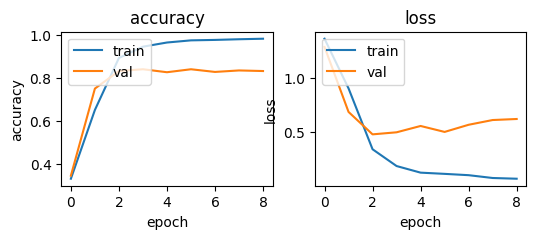

In [25]:
# Plot model history
plot_history(model_bi_lstm_history, test_score, val_score)

## GRU

In [26]:
# Create callbacks
es, checkpoint = create_callbacks('text_classifier_gru.hdf5', monitor, mode, patience)
# Build model architecture
model_gru = build_gru_model(input_dim, n_outputs, metrics)
# Fit the model
model_gru, model_gru_history = fit_model(model_gru, es, checkpoint)

Epoch 1/15
91/91 - 4s - loss: 1.3493 - accuracy: 0.3325 - val_loss: 1.2285 - val_accuracy: 0.4564 - 4s/epoch - 45ms/step
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 - 1s - loss: 0.9808 - accuracy: 0.5401 - val_loss: 0.8910 - val_accuracy: 0.5989 - 1s/epoch - 12ms/step
Epoch 3/15
91/91 - 1s - loss: 0.5906 - accuracy: 0.7689 - val_loss: 0.6819 - val_accuracy: 0.7773 - 1s/epoch - 12ms/step
Epoch 4/15
91/91 - 1s - loss: 0.2857 - accuracy: 0.9138 - val_loss: 0.6811 - val_accuracy: 0.7801 - 1s/epoch - 12ms/step
Epoch 5/15
91/91 - 1s - loss: 0.1671 - accuracy: 0.9519 - val_loss: 0.7432 - val_accuracy: 0.8091 - 1s/epoch - 12ms/step
Epoch 6/15
91/91 - 1s - loss: 0.1318 - accuracy: 0.9651 - val_loss: 0.6972 - val_accuracy: 0.8091 - 1s/epoch - 13ms/step
Epoch 7/15
91/91 - 1s - loss: 0.1188 - accuracy: 0.9696 - val_loss: 0.7192 - val_accuracy: 0.8174 - 1s/epoch - 12ms/step
Epoch 8/15
91/91 - 1s - loss: 0.0959 - accuracy: 0.9754 - val_loss: 0.7181 - val_accuracy: 0.8230 - 1s/epoch - 11ms/step
Epoch 9/15
91/91 - 1s - loss: 0.0818 - accuracy: 0.9813 - val_loss: 0.8399 - val_accuracy: 0.8202 - 1s/epoch - 11ms/step
Epoch 10/15
91/91 - 1s - loss: 0.0899 - acc

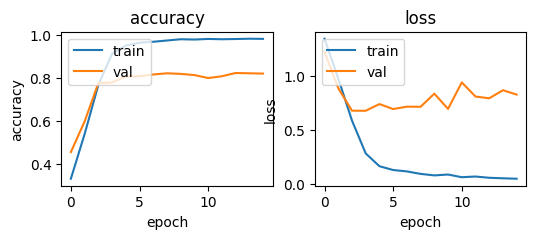

In [27]:
# Plot model history
plot_history(model_gru_history, test_score, val_score)

## CNN

In [28]:
# Create callbacks
es, checkpoint = create_callbacks('text_classifier_cnn.hdf5', monitor, mode, patience)
# Build model architecture
model_cnn = build_cnn_model(input_dim, n_outputs, metrics)
# Fit the model
model_cnn, model_cnn_history = fit_model(model_cnn, es, checkpoint)

Epoch 1/15
91/91 - 1s - loss: 1.3686 - accuracy: 0.3125 - val_loss: 1.3372 - val_accuracy: 0.3237 - 1s/epoch - 14ms/step
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 - 0s - loss: 1.1752 - accuracy: 0.5007 - val_loss: 0.9779 - val_accuracy: 0.6805 - 480ms/epoch - 5ms/step
Epoch 3/15
91/91 - 0s - loss: 0.6072 - accuracy: 0.8484 - val_loss: 0.4958 - val_accuracy: 0.8534 - 419ms/epoch - 5ms/step
Epoch 4/15
91/91 - 0s - loss: 0.2422 - accuracy: 0.9381 - val_loss: 0.4148 - val_accuracy: 0.8631 - 408ms/epoch - 4ms/step
Epoch 5/15
91/91 - 0s - loss: 0.1314 - accuracy: 0.9664 - val_loss: 0.4193 - val_accuracy: 0.8658 - 464ms/epoch - 5ms/step
Epoch 6/15
91/91 - 0s - loss: 0.0981 - accuracy: 0.9754 - val_loss: 0.4470 - val_accuracy: 0.8658 - 427ms/epoch - 5ms/step
Epoch 7/15
91/91 - 0s - loss: 0.0771 - accuracy: 0.9782 - val_loss: 0.4466 - val_accuracy: 0.8645 - 405ms/epoch - 4ms/step
Epoch 8/15
91/91 - 0s - loss: 0.0725 - accuracy: 0.9827 - val_loss: 0.4618 - val_accuracy: 0.8603 - 409ms/epoch - 4ms/step
Epoch 9/15
91/91 - 0s - loss: 0.0733 - accuracy: 0.9824 - val_loss: 0.4933 - val_accuracy: 0.8645 - 359ms/epoch - 4ms/step
Epoch 10/15
91/91 - 0s - lo

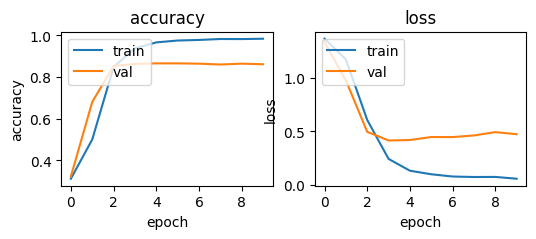

In [29]:
# Plot model history
plot_history(model_cnn_history, test_score, val_score)

## CNN + GRU

In [32]:
# Create callbacks
es, checkpoint = create_callbacks('text_classifier_cnn_gru.hdf5', monitor, mode, patience)
# Build model architecture
model_cnn_gru = build_cnn_gru_model(input_dim, n_outputs, metrics)
# Fit the model
model_cnn_gru, model_cnn_gru_history = fit_model(model_cnn_gru, es, checkpoint)

Epoch 1/15
91/91 - 3s - loss: 1.3669 - accuracy: 0.3121 - val_loss: 1.3486 - val_accuracy: 0.3320 - 3s/epoch - 36ms/step
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 - 1s - loss: 1.0141 - accuracy: 0.6612 - val_loss: 0.9633 - val_accuracy: 0.6058 - 591ms/epoch - 6ms/step
Epoch 3/15
91/91 - 1s - loss: 0.3188 - accuracy: 0.9232 - val_loss: 0.8419 - val_accuracy: 0.6611 - 619ms/epoch - 7ms/step
Epoch 4/15
91/91 - 1s - loss: 0.1283 - accuracy: 0.9682 - val_loss: 0.8886 - val_accuracy: 0.6653 - 631ms/epoch - 7ms/step
Epoch 5/15
91/91 - 1s - loss: 0.0748 - accuracy: 0.9806 - val_loss: 0.9358 - val_accuracy: 0.6625 - 550ms/epoch - 6ms/step
Epoch 6/15
91/91 - 1s - loss: 0.0641 - accuracy: 0.9841 - val_loss: 0.9453 - val_accuracy: 0.6722 - 668ms/epoch - 7ms/step
Epoch 7/15
91/91 - 1s - loss: 0.0590 - accuracy: 0.9830 - val_loss: 0.9848 - val_accuracy: 0.6763 - 642ms/epoch - 7ms/step
Epoch 8/15
91/91 - 1s - loss: 0.0490 - accuracy: 0.9848 - val_loss: 1.0299 - val_accuracy: 0.6736 - 565ms/epoch - 6ms/step
Epoch 9/15
91/91 - 1s - loss: 0.0487 - accuracy: 0.9844 - val_loss: 1.0401 - val_accuracy: 0.6805 - 639ms/epoch - 7ms/step
Epoch 10/15
91/91 - 1s - lo

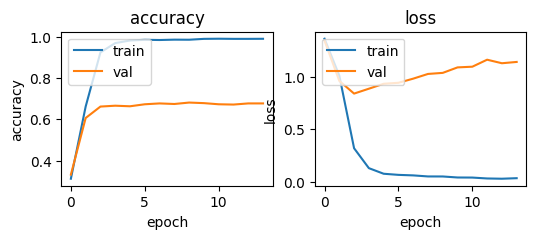

In [34]:
# Plot model history
plot_history(model_cnn_gru_history, test_score, val_score)

# Invoke prediction

In [35]:
# Load model and tokenizer
loaded_model = load_model('text_classifier_lstm.hdf5')
loaded_tokenizer = pickle.load(open('text_emotion_tokenizer.pickle', 'rb'))

In [36]:
def prepare_input_text(input_text):
    input_text = pd.DataFrame({'input_text': [input_text]})
    input_text['input_text'] = input_text['input_text'].apply(clean_text)
    seq_input_text = loaded_tokenizer.texts_to_sequences(input_text['input_text'])
    pad_input_text = pad_sequences(seq_input_text)
    return pad_input_text

In [46]:
input_text = "my toy is all break"
input_text = prepare_input_text(input_text)
input_text

array([[586, 586, 586, 586, 122]], dtype=int32)

In [47]:
model_lstm.predict(input_text, verbose=0)

array([[0.50092816, 0.3775458 , 0.60425586, 0.5637668 ]], dtype=float32)

In [48]:
loaded_model.predict(input_text, verbose=0)

array([[0.50092816, 0.3775458 , 0.60425586, 0.5637668 ]], dtype=float32)